###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

**NOTE:** Do not modify any of the cells (with code) provided in this notebook or you might have problems finishing the assignment.

## Motivation

Assume you are building a Ridge Linear Regression model and wish to compute the performance of your model under different regularization parameters. Your main task is to plot the train and test MSE versus the regularization parameter $\lambda$ as shown inthe figure below.
<p><span style="color:red"><b>Note: </b> Do not use any sklearn or external implementation. You are allowed to use functions in numpy.</span></p>

In [52]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple
import statistics as stats
import math
import random
import numpy.linalg as alg

### 1. Read dataset
Here we read the dataset from the file. Two variables are created:
* `predictors`: which is the predictors matrix (or feature matrix) of size `[m x d]` (`m` observations and `d` features). Notice that in this problem `d = 2`, so originally there is only two features.
* `responses`: which is the responses matrix (ground truth) of size `[m x 1]`.

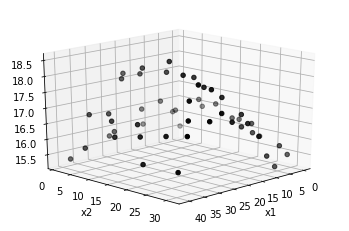

In [53]:
# Reading and plotting data. Do not modify this cell!
dataset = sio.loadmat('data.mat')
predictors = dataset['X']
responses = dataset['y']
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(predictors[:,0], predictors[:,1], responses, color='k')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.view_init(20, azim=45)

### 2. Adding exponential features
Since the data is clearly not following a linear trend (just a simple plane doesn't seem like a good model) you decide to add polynomial features to the problem. In order to do so you must complete the function `expand` declared below.

Details about the `expand` function:
* It takes two arguments: A numpy array `data` of size `[m x d]` (`m` observations and `d` features) and an integer `degree`.
* It will add all polynomial terms (up to `degree`) of each single feature in the `data` matrix. For instance if the $i^{th}$ observation in `data` is $x(i) = [x_1, x_2]$ then the expanded observation will be $\phi(𝑥(𝑖)) = [𝑥_1,  
𝑥_1^2,...,𝑥_1^{\text{degree}}, 𝑥_2, 𝑥_2^2, ...,𝑥_2^{\text{degree}}]$.
* It should return a numpy array of size `[m x (d * degree)]` corresponding to the expanded version of `data` where each observation has been expanded as explained before.

<p><span style="color:red"><b>Note: </b> Do not use any sklearn or external implementation. You must code this from scratch.</span></p> 

In [54]:
# Complete this function's implementation
def expand(data: np.ndarray, degree: int) -> np.ndarray:

    num_features = len(data[0, :])
    num_observations = len(data[:, 0])

    poly = np.array([[None] * degree] * 1)
    expanded = np.array([[None] * (num_features*degree)] * 1)
    output = np.array([[None] * (num_features*degree)] * num_observations)
    for i in list(range(num_observations)):
        for j in list(range(num_features)):
            value = data[i, j]
            for k in list(range(degree)):
                poly[0, k] = pow(value, k+1)
            expanded[0, [range((j*degree),(j*degree)+degree)]] = poly
        output[i, :] = expanded
    return output

In [55]:
# Do not modify this cell!
expanded_predictors = expand(predictors, 10)

#### Unit test
If your implementation is correct, the function call in the cell below will produce the following output: `Passed`.

In [56]:
# Do not modify this cell!
def unit_test():
    try:
        x = np.random.rand(10,3)
        expanded = expand(x,3)
        outcome = True
        outcome = outcome & (expanded[:,0] == x[:,0]).all()
        outcome = outcome & (expanded[:,2] == x[:,0]**3).all()
        outcome = outcome & (expanded[:,3] == x[:,1]).all()
        outcome = outcome & (expanded[:,4] == x[:,1]**2).all()
        if outcome:
            print('Passed')
        else:
            print('Not passed')            
    except:
        print('Not passed')
unit_test()

Passed


### 3. Normalizing predictors (features)
Use standardization to normalize your dataset contained in `expanded_predictors` before training. For that you will implement the function `normalize`.

Details about the `normalize` function:
* It takes a numpy array `data` of size `[m x d]` (`m` observations and `d` features).
* It returns the corresponding normalized version of `data` using standardization (substracting the mean and dividing by the standard deviation).

<p><span style="color:red"><b>Note: </b> Do not use any sklearn or external implementation. You must code this from scratch.</span></p>

In [57]:
# Complete this function's implementation
def normalize(data: np.ndarray) -> np.ndarray:

    num_columns = len(data[0, :])
    num_rows = len(data[:, 0])

    normalized = np.array([[None] * num_columns] * num_rows)
    for i in list(range(num_columns)):
        mean = np.mean(data[:, i])
        sd = np.std(data[:, i])
        normalized[:, i] = ((data[:, i] - mean)/sd)
    return normalized.astype("float64")

In [58]:
# Do not modify this cell!
normalized_predictors = normalize(expanded_predictors)

#### Unit test
If your implementation is correct, the function call in the cell below will produce the following output: `Passed`.

In [59]:
# Do not modify this cell!
def unit_test():
    try:
        x = np.random.randint(0,1000,(1000,3))
        normalized = normalize(x)
        outcome = True
        outcome = outcome & (abs(normalized.mean(axis=0)) < 1e-5).all()
        outcome = outcome & (abs(normalized.std(axis=0) - 1) < 1e-5).all()
        if outcome:
            print('Passed')
        else:
            print('Not passed')            
    except:
        print('Not passed')
unit_test()

Passed


### 4. Preparing for finding parameters 
In this problem we will focused on determining the weights of a ridge linear regression model while also trying to find the best regularization parameter $\lambda$. To do we will split the dataset as follows:
* 70% for training. These observations will be used to find the weights of the ridge linear regression model.
* 30% for testing. These observations will be used to analyze the performance of our regression model on unseen data.

To perform this you need to implement the function `train_test_split`.

Details about the `train_test_split` function:
* It takes two numpy arrays: `X` of size `[m x n]` and `y` of size `[m x 1]` and a floating-point number `train_pct` between 0 and 1. Notice that there is a one-to-one correspondance between the rows of `X` and `y`.
* It returns a tuple of four numpy arrays:
    * The first containing `train_pct * m` random rows from `X`.
    * The second containing the remaining `(1 - train_pct) * m` rows from `X` (This and second array should be non-overlapping sets of `X`,i.e., they shouldn't have any row in common).
    * The third containing those rows from `y` corresponding to the `train_pct * m` random rows selected from `X`.
    * The fourth containing the rest of the rows from `y` (this and the third array should be non-overlapping sets of `y`,i.e., they shouldn't have any row in common).

<p><span style="color:red"><b>Note: </b> Do not use any sklearn or external implementation. You must code this from scratch.</span></p>

In [60]:
# Complete this function's implementation
def train_test_split(X: np.ndarray, y: np.ndarray, train_pct: float) -> Tuple:
    taining_frac = train_pct
    len_train = math.floor(len(X[:, 0]) * taining_frac)
    len_test = len(X[:, 0]) - len_train
    random_indices_train = np.sort(random.sample(range(0, len(X[:, 0])), len_train))
    random_indices_test = np.sort(np.setdiff1d(range(len(X[:, 0])), random_indices_train))
    T = (X[random_indices_train], X[random_indices_test], y[random_indices_train], y[random_indices_test])
    return T

In [61]:
# Do not modify this cell!
final_predictors = np.hstack((np.ones((normalized_predictors.shape[0],1)), normalized_predictors))
X_train, X_test, y_train, y_test = train_test_split(final_predictors, responses, 0.7)

#### Unit test
If your implementation is correct, the function call in the cell below will produce the following output: `Passed`.

In [62]:
# Do not modify this cell!
def unit_test():
    try:
        m = 1000
        x = np.random.randint(0,1000,(m,3))
        y = np.random.randint(0,2,(m,))
        x_train, x_test, y_train, y_test = train_test_split(x,y,0.7)
        outcome = True
        for train_obs in x_train:
            for test_obs in x_test:
                outcome = outcome & ~(train_obs == test_obs).all()
        outcome = outcome & ((x_train.shape[0] + x_test.shape[0]) == m)
        outcome = outcome & ((y_train.shape[0] + y_test.shape[0]) == m)
        if outcome:
            print('Passed')
        else:
            print('Not passed')            
    except:
        print('Not passed')
unit_test()

Passed


### 5. Training and exploring different values of $\lambda$
In this part we will train a ridge regression model under different values of regularization for $\lambda$.
For this you have to do two things:
1. Implement the function `r2score` to compute the [R2 Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (A very useful metric for regression problems).
2. Implement the actual training (finding weights) of a ridge regression model where you try all values of $\lambda$ provided in the variable `values` below.

### 5.1 Computing R2 Coefficient of Determination
For this you need to complete the function `r2score` definition below. To do so visit the [Definition](https://en.wikipedia.org/wiki/Coefficient_of_determination#Definitions) section from Wikipedia.

Details about the `r2score` function:

* It receives two same-size numpy arrays `y_pred` and `y_true`. The array `y_pred` represents your model prediction (`f` term in Wikipedia's definition) while the array `y_true` represents the expected output ("observed data" or `y` from Wikipedia definition).
* It returns the R2 score.


<p><span style="color:red"><b>Note: </b> Do not use any sklearn or external implementation. You must code this from scratch.</span></p>

In [63]:
def r2score(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    y = y_true.reshape(len(y_true),)
    f = y_pred.reshape(len(y_pred),)
    SStot = sum(pow(y - np.mean(y), 2))
    SSres = sum(pow(y - f, 2))
    R2 = 1 - (SSres/SStot)
    return R2

#### Unit test
If your implementation is correct, the function call in the cell below will produce the following output: `Passed`.

In [64]:
# Do not modify this cell!
def unit_test():
    try:
        y_true = np.array([4, 5, 9, 3, 7])
        y_pred = np.array([9, 9, 5, 2, 9])
        outcome = True
        outcome = outcome & (r2score(y_pred, y_pred) == 1.0)
        outcome = outcome & (abs(r2score(y_pred, y_true) - (-1.6724137931034484)) < 1e-5)
        if outcome:
            print('Passed')
        else:
            print('Not passed')            
    except:
        print('Not passed')
unit_test()

Passed


### 5.2 Training models
For every regularization value defined in `values` train a ridge regression model complying with the following constraints:
1. Use `X_train` and `y_train` for training.
2. Use `X_test` and `y_test` for testing.
3. Create a python list named `metrics`. After every training append a python tuple to the list `metrics` with the following data (training set R2 score, test set R2 score).
4. Create a python list named `weights`. After every training append the resulting weight vector to the list `weights`.

<p><span style="color:red"><b>Note: </b> Do not use any sklearn or external implementation. You must code this from scratch.</span></p>

In [65]:
# Regularization values to try. Do not modify this cell!!!
values = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8, 1, 3, 6, 12]

In [66]:
# CODE HERE
weights = list()
metrics = list()
for i in list(range(len(values))):
    d = 20
    regularization = values[i]
    diagonal = np.diag(np.concatenate(([0], regularization * np.ones(d))))

    m = len(X_train)
    XX = np.concatenate((X_train, np.sqrt(diagonal)))
    yy = np.concatenate((y_train, np.zeros([d + 1, 1])))
    wmap = alg.pinv(XX).dot(yy)
    #wmap = alg.lstsq(XX,yy,rcond=None)[0] 

    y_pred_train = np.dot(X_train, wmap)
    r2_train = r2score(y_pred_train, y_train)

    y_pred_test = np.dot(X_test, wmap)
    r2_test = r2score(y_pred_test, y_test)

    metrics.append((r2_train, r2_test))
    weights.append(list(wmap))

#### Unit test
If everything is correct you should see a graph where the performance of the model decreases as you increase $\lambda$.

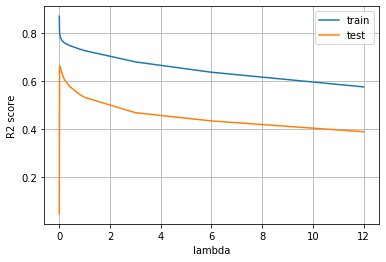

In [67]:
# Plotting computed performance. Do not modify this cell!
axes = plt.plot(values, metrics)
plt.xlabel('lambda')
plt.ylabel('R2 score')
plt.legend(axes, ['train', 'test'])
plt.grid()
plt.show()

#### Question
Give your opinion on the observed behavior of the figure above.

<span style="color:red">As the degree of regularization (the $\lambda$ value) increases, there is a greater penalty on the size of the weights ($w_0, w_1, w_2...$). While this helps prevent overfitting and 'smooths' out the regression line/plane, it simultaneously has an adverse effect on the R2 score. This is beacuse the regression model no longer tries to perfectly 'fit' the dataset.</span> 

#### Unit test
If everything is correct you should see a collection of subplots showing the resulting models obtained during your training for the different values of $\lambda$.

**Notice:** 
1. These models are shown in the original two features space. The polynomial features are used only to allow for more complex models (non linear).
2. The surface represents the values (on the z axis) the model will output for any given combination of $x_1$ and $x_2$ shown in the graphs below.

In [68]:
# Generates auxiliary grid for plotting. Do not modify this cell!
pts = 200
x1 = np.linspace(predictors[:,0].min(), predictors[:,0].max(), pts)
x2 = np.linspace(predictors[:,1].min(), predictors[:,1].max(), pts)
X1, X2 = np.meshgrid(x1,x2)
grid = np.array([X1.ravel(), X2.ravel()]).T
final_grid = np.hstack((np.ones((pts*pts,1)), normalize(expand(grid, 10))))

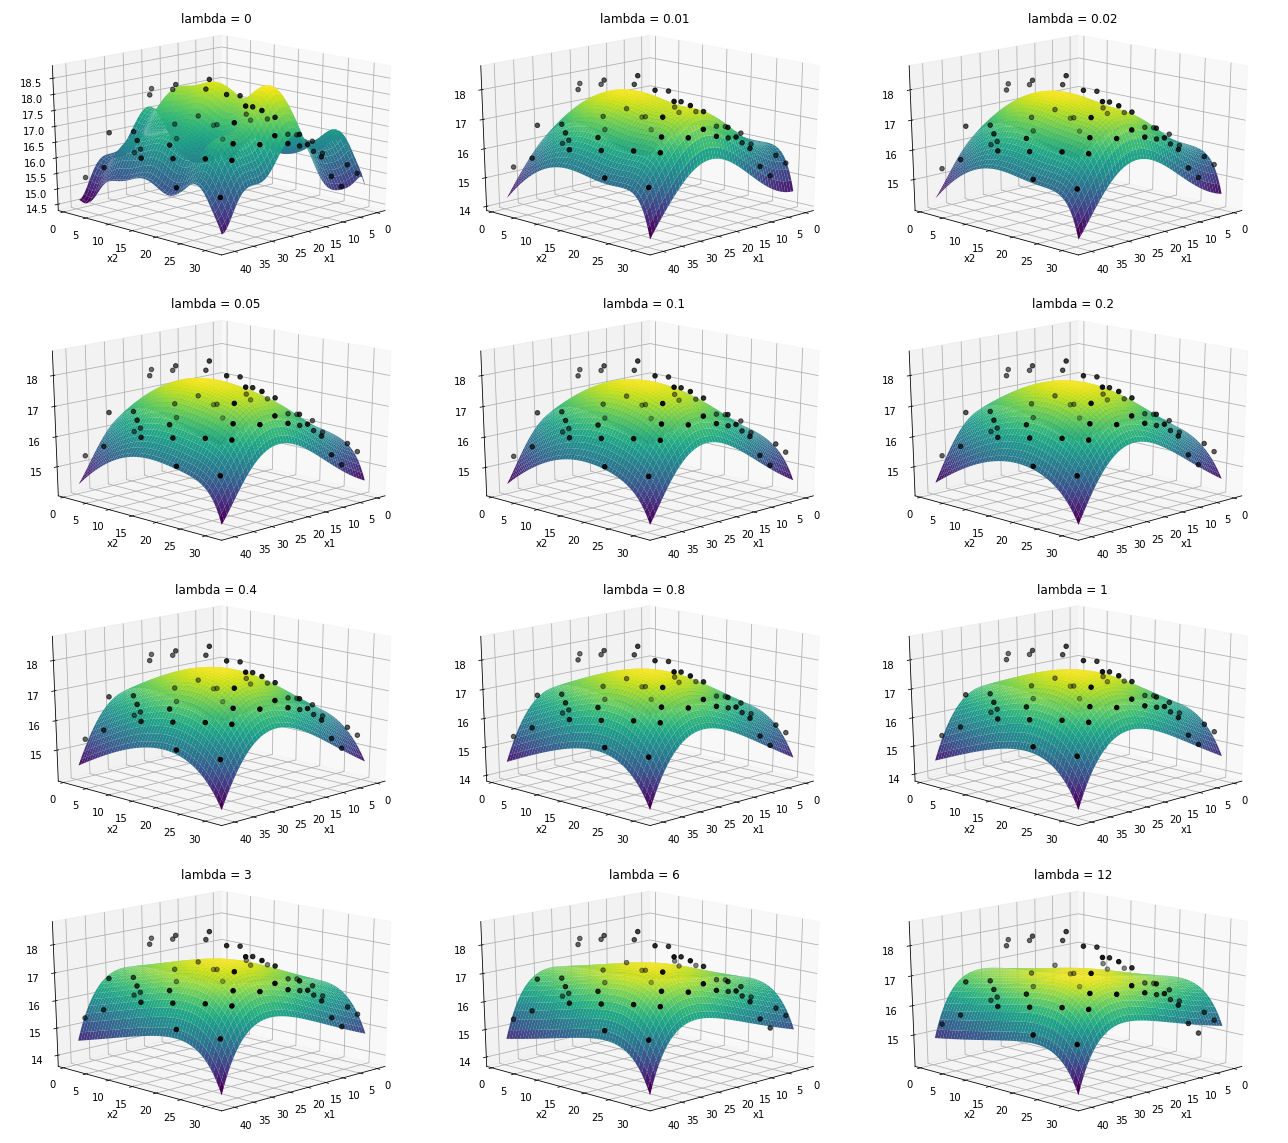

In [69]:
# Resulting models for given values of lambda. Do not modify this cell!
amount = len(values)
fig = plt.figure()
fig.set_size_inches(6*3, 4*np.ceil(amount/3))
for index, (reg, w) in enumerate(zip(values, weights)):
    ax = fig.add_subplot(np.ceil(amount/3), 3, index + 1, projection='3d')
    ax.plot_surface(X1, X2, final_grid.dot(w).reshape((pts,pts)), cmap='viridis')
    ax.scatter(predictors[:,0], predictors[:,1], responses, color='k')
    ax.set_title("lambda = {}".format(reg))
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.view_init(20, azim=45)
plt.tight_layout()
plt.show()

#### Question
Give your opinion on the observed behavior of the figure above.

*Enter your answer here!*

<span style="color:red">This graph visually shows the effect that increasing our regularization parameter $\lambda$ has on the output of our regression model. In the first graph, where $\lambda = 0$, the regression model has a lot of small perturbations. This is the case because the model is trying to 'fit' the data as closely as possible. To the point that we can say the data is being 'overfit' i.e. it is even modeling noise in the data. This problem can be circumvented by increasing our regularization parameter as can be seen in the subsequent plots above. As the $\lambda$ value increases, the regression plane smooths out and no longer fits the data as closely. However, care should be taken to not increase the $\lambda$ value too much, as this results in underfitting</span> 